 # Skin Diasese detection test

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
tf.__version__

'2.10.0'

## Processing the training set

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.9,1.1],
#     fill_mode='nearest'
# )
# training_set = train_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/train',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

Found 30909 images belonging to 6 classes.


## Preprocessing the test set

In [ ]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/test',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

Found 3928 images belonging to 6 classes.


In [2]:

# Common parameters
BATCH_SIZE   = 32
IMG_SIZE     = (256, 256)
DATA_DIR     = r"C:\Users\User\Downloads\Skin-disease-dataset\train"
SEED         = 42           # keeps split reproducible
VAL_SPLIT    = 0.20         # 80 % train, 20 % validation

datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VAL_SPLIT      # ← **key line**
)

training_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',              # ← **80 % of images**
    shuffle=True,
    seed=SEED
)

test_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # ← **20 % of images**
    shuffle=True,
    seed=SEED
)


Found 34772 images belonging to 5 classes.
Found 8689 images belonging to 5 classes.


## Building the CNN

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(256, 256, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:50]:  
    layer.trainable = False



# Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


# Compile Model
model.compile(optimizer=Adam(1e-4),  # use a smaller learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
callbacks = [
    EarlyStopping(monitor='val_loss',mode='max', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

model.fit(training_set,
          validation_data=test_set,
          epochs=15,
          callbacks=callbacks,  
          verbose=1)


Epoch 1/15
1087/1087 [==============================] - 1555s 1s/step - loss: 0.7217 - accuracy: 0.7072 - val_loss: 1.1598 - val_accuracy: 0.6355 - lr: 1.0000e-04
Epoch 2/15
1087/1087 [==============================] - 1110s 1s/step - loss: 0.3305 - accuracy: 0.8819 - val_loss: 0.9323 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 3/15
1087/1087 [==============================] - 1032s 949ms/step - loss: 0.1905 - accuracy: 0.9344 - val_loss: 1.0923 - val_accuracy: 0.7595 - lr: 1.0000e-04
Epoch 4/15
1087/1087 [==============================] - 1013s 931ms/step - loss: 0.1261 - accuracy: 0.9583 - val_loss: 0.9739 - val_accuracy: 0.8284 - lr: 1.0000e-04
Epoch 5/15
1087/1087 [==============================] - 988s 908ms/step - loss: 0.1016 - accuracy: 0.9669 - val_loss: 0.9409 - val_accuracy: 0.8428 - lr: 1.0000e-04
Epoch 6/15
1087/1087 [==============================] - 1000s 920ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.9143 - val_accuracy: 0.8591 - lr: 2.0000e-05
Epoch 7/15


1/1 [==============================] - 1s 756ms/step


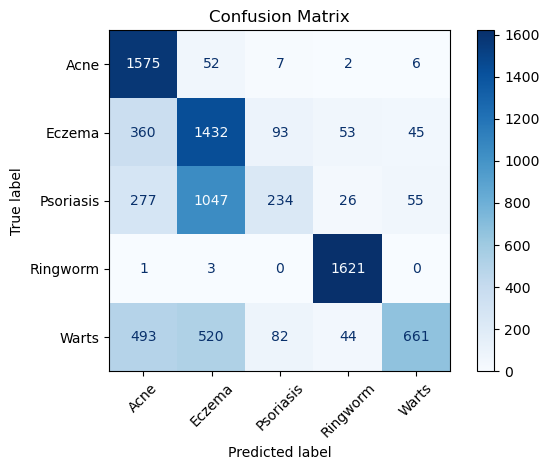

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# eval_datagen = ImageDataGenerator(rescale=1./255)

# eval_set = eval_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/val',
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='categorical',
#     shuffle=False  # Important: keep order for correct confusion matrix
# )
# import numpy as np
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Predict
# y_true = eval_set.classes
# y_pred_probs = model.predict(eval_set)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Class names
# class_labels = list(eval_set.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap='Blues', xticks_rotation=45)
# plt.title("Confusion Matrix on Custom Eval Folder")
# plt.tight_layout()
# plt.show()


In [5]:
model.save('299-model-test-v2.h5')

In [9]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array  # ✅ Modern import

# Load and preprocess the image
test_image = load_img('C:/Users/User/Downloads/Skin-disease-dataset/single-prediction/Eczema3.jpg', target_size=(128, 128))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict using the CNN model
result = model.predict(test_image)

# Define class labels in the same order as training_set.class_indices
class_labels = [
    "Acne",
    "Eczama",
    "Psoriasis",
    "Rigworm",
    "Warts"
]

# Get the predicted class index
predicted_index = np.argmax(result[0])
prediction = class_labels[predicted_index]

print("Predicted class:", prediction)

1/1 [==============================] - 0s 23ms/step
Predicted class: Warts
